In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt 
%matplotlib inline

# HW 1

In [2]:
data = pd.read_csv('All_GPUs.csv')

data['Resolution_W'], data['Resolution_H'] = data['Resolution_WxH'].str.split('x').str
data['Core_Speed_MHz'] = data['Core_Speed'].str.replace(' MHz', '')
data['Memory_Speed_MHz'] = data['Memory_Speed'].str.replace(' MHz', '')
data['Max_Power_Watts'] = data['Max_Power'].str.replace(' Watts', '')
data['Release_Price_Dollars'] = data['Release_Price'].str.replace('$', '')
data['Memory_MB'] = data['Memory'].str.replace(' MB', '')
data['Memory_Bus_Bit'] = data['Memory_Bus'].str.replace(' Bit', '')
data['Memory_Bandwidth_GB_Sec'] = data['Memory_Bandwidth'].str.replace('GB/sec', '')

all_features = [
    "Resolution_W",
    "Resolution_H",
    "Core_Speed_MHz",
    "Memory_Speed_MHz",
    "Max_Power_Watts",
    "Release_Price_Dollars",
    "Memory_MB",
    "Memory_Bus_Bit",
    "Memory_Bandwidth_GB_Sec"
]

data = data[all_features].dropna()

for col in data.columns:
    data = data[pd.to_numeric(data[col], errors='coerce').notnull()]
    
data = data.dropna().drop_duplicates().astype('float').astype('int').reset_index(drop=True)

Let's select a dataset with some information about computer parts, specifically, GPUs.

Source is kaggle: https://www.kaggle.com/iliassekkaf/computerparts#All_GPUs.csv

Original dataset contains 3405 rows of 34 features.

We selected meaningful features: "Resolution_W", "Resolution_H", "Core_Speed_MHz", "Memory_Speed_MHz", "Max_Power_Watts", "Release_Price_Dollars", "Memory_MB", "Memory_Bus_Bit", "Memory_Bandwidth_GB_Sec".

Of course, there a lot of NaN values, also some numerical features represented as strings, for example, "2560x1600" as screen resolution. We can transform this single feature into two numerical: width and height. Some rows contains incorrect values - that cannot be represented as string, even if the feature is numerical. Let's delete such strings.

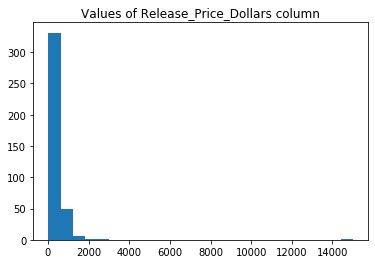

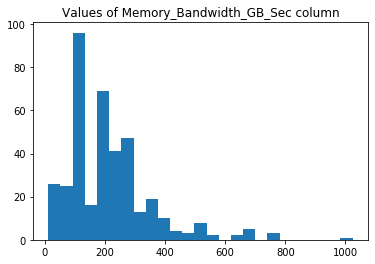

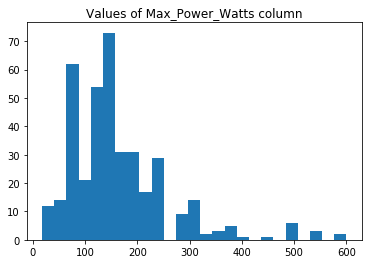

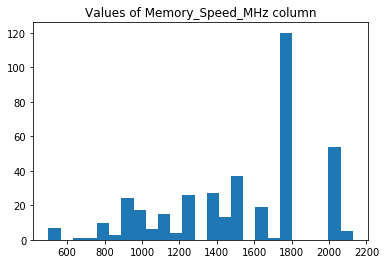

In [3]:
value_max = {
    'Release_Price_Dollars' : 450,
    'Memory_Bandwidth_GB_Sec' : 300,
    'Max_Power_Watts' : 200,
    'Memory_Speed_MHz' : 1800
}

for k in value_max.keys():
    plt.title('Values of {} column'.format(k))
    plt.hist(data[k], bins=25)
    plt.show()

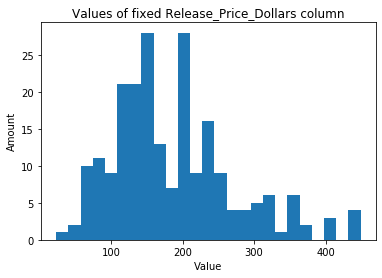

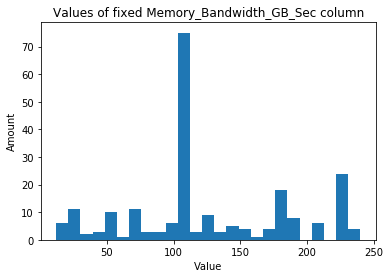

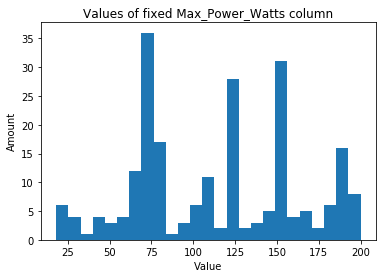

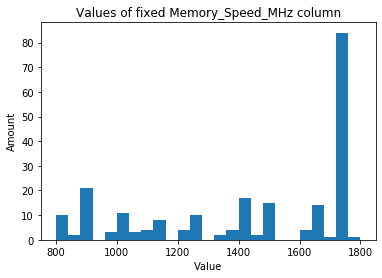

In [4]:
for k in value_max.keys():
    data = data[data[k] <= value_max[k]].reset_index(drop=True)
    
for k in value_max.keys():
    plt.title('Values of fixed {} column'.format(k))
    plt.hist(data[k], bins=25)
    plt.xlabel('Value')
    plt.ylabel('Amount')
    plt.show()

Some values are suspiciously big, for example single row with "14999" in "Release_Price_Dollars". Other prices are significantly lesser. So also we detected such outliers and also removed them. We can do that by checking values histograms. We don't need too much data, so we can remove some rare values.

After 9 features selection, nulls drop and some transformation and cleanup it's containing 220 lines. 

This dataset is suitable for cluster analysis: all features are numerical and defenitely we can divide these devices into groups.

In [5]:
data

,Resolution_W,Resolution_H,Core_Speed_MHz,Memory_Speed_MHz,Max_Power_Watts,Release_Price_Dollars,Memory_MB,Memory_Bus_Bit,Memory_Bandwidth_GB_Sec
0,2560,1600,960,1050,190,249,1024,256,134
1,2560,1600,850,975,190,249,1024,256,124
2,2560,1600,575,900,95,130,512,256,57
3,2560,1600,750,800,80,109,512,128,51
4,2560,1600,750,800,59,67,512,128,25
...,...,...,...,...,...,...,...,...,...
215,4096,2160,993,1250,64,89,1024,128,80
216,4096,2160,993,900,64,79,2048,128,28
217,4096,2160,797,1250,19,59,1024,64,40
218,4096,2160,902,900,23,89,2048,64,14


# HW 2

In [6]:
def get_model(init_centers, use_minibatch):
    n_clusters = len(init_centers)
    if use_minibatch:
        return MiniBatchKMeans(n_clusters=n_clusters, batch_size=10, init=init_centers)
    else:
        return KMeans(n_clusters=n_clusters, init=init_centers)

def get_stats(model, X, Y, n_clusters):
    GMean = np.mean(X, axis=0)
    for j in range(n_clusters):
        cluster = X[np.where(Y==j)]
        CMean = np.mean(cluster, axis=0)
        d = 100 * (np.divide(np.subtract(CMean, GMean), GMean))
        print("cluster {},\telements: {},\tdelta: {}".format(j+1, cluster.shape[0], d))

Let's select features, that have wide range of values. For example, screen resolution is not suitable : it looks like categorical feature with poor values range. Afted histogram analysis it is clear, that 'Release_Price_Dollars', 'Core_Speed_MHz', 'Max_Power_Watts', 'Memory_Bandwidth_GB_Sec' can be taken.

In [7]:
selected_features = [
    'Release_Price_Dollars',
    'Core_Speed_MHz',
    'Max_Power_Watts',
    'Memory_Bandwidth_GB_Sec'
]

X = np.array(data[selected_features])

In [8]:
def clusterize(X, K, n_inits, use_minibatch):

    X_norm = np.divide(np.subtract(X, np.mean(X, axis=0)), np.ptp(X, axis=0) )
    
    best = {
        'inertia' : np.infty
    }
    
    for i in range(n_inits):
        print('initialization {}'.format(i+1))
        init_centers = X_norm[np.random.choice(len(X_norm), K, replace=False)]
        model = get_model(init_centers, use_minibatch)
        model.fit(X_norm)
        Y = model.labels_
        get_stats(model, X, Y, K)
        inertia = model.inertia_
        print('inertia = {}\n'.format(inertia))

        if inertia < best['inertia']:
            best = {
                'init' : i+1,
                'inertia' : inertia,
                'init_centers' : init_centers,
                'labels' : Y,
                'selected_features' : selected_features,
            }

    print('Best score {} on init {}'.format(best['inertia'], best['init']))
               
    return best

In [9]:
np.random.seed(13)
best5 = clusterize(X, 5, 10, False)

initialization 1
cluster 1,	elements: 52,	delta: [-27.2838156   20.59355259 -34.27194792 -13.83173284]
cluster 2,	elements: 28,	delta: [ 42.15801083 -23.71344505  41.44547726  -6.59695857]
cluster 3,	elements: 32,	delta: [ -6.71721683  13.05585891   6.69850978 -14.81557966]
cluster 4,	elements: 40,	delta: [-48.68353439 -20.25280468 -50.40642308 -65.98549059]
cluster 5,	elements: 68,	delta: [35.30332974 -0.21417016 35.64077263 59.08063412]
inertia = 12.049142408736376

initialization 2
cluster 1,	elements: 56,	delta: [-27.85394433  19.29103934 -32.86192431 -14.32881154]
cluster 2,	elements: 37,	delta: [-52.08848215 -18.75084919 -53.61133935 -66.87917626]
cluster 3,	elements: 28,	delta: [ -2.63887384  14.58407203   9.73138508 -13.9619718 ]
cluster 4,	elements: 25,	delta: [ 30.70692735 -28.59734469  33.94429613 -17.70147967]
cluster 5,	elements: 74,	delta: [37.74743251 -1.08023219 36.52433962 55.54615095]
inertia = 12.301514423105102

initialization 3
cluster 1,	elements: 36,	delta: [-48.

In [10]:
np.random.seed(13)
best9 = clusterize(X, 9, 10, False)

initialization 1
cluster 1,	elements: 20,	delta: [-21.69965987  34.08350407 -34.25509025 -11.50696739]
cluster 2,	elements: 11,	delta: [  3.45755744 -34.25814778   6.94505319 -46.41574486]
cluster 3,	elements: 25,	delta: [ -1.01157413  17.18295622  10.27612862 -14.0037351 ]
cluster 4,	elements: 19,	delta: [-37.49686081  -0.16545194 -31.85597775 -37.70556257]
cluster 5,	elements: 38,	delta: [60.55033465 -0.36662593 54.60434567 56.25590697]
cluster 6,	elements: 28,	delta: [-53.64579874 -22.20650636 -59.14423466 -70.56816549]
cluster 7,	elements: 26,	delta: [-31.44553345  14.47824538 -32.90647672 -11.50696739]
cluster 8,	elements: 31,	delta: [ 2.92554052 -0.10763655 11.80876265 61.08178747]
cluster 9,	elements: 22,	delta: [ 48.26143343 -21.30202081  46.71076224   2.32006896]
inertia = 7.3985639754213

initialization 2
cluster 1,	elements: 39,	delta: [-27.18719197  25.65623016 -33.35601456 -11.50696739]
cluster 2,	elements: 22,	delta: [ 36.54048499 -27.50254971  39.25967247 -11.93793995]
c

Best for 5 clusters:

```
cluster 1,	elements: 40,	delta: [63.26253456 -1.12886631 55.26756186 54.4875018 ]
cluster 2,	elements: 30,	delta: [ 2.24712686e+00 -2.10595353e-02  1.14449270e+01  6.26586218e+01]
cluster 3,	elements: 27,	delta: [ 36.07828104 -23.53550153  38.79480947  -7.87828484]
cluster 4,	elements: 41,	delta: [-48.37268068 -19.72794896 -50.4400973  -65.27342231]
cluster 5,	elements: 82,	delta: [-19.3749862   18.17184008 -18.70080672 -14.27237466]
inertia = 11.214650925809542
```

Best for 9 clusters:

```
cluster 1,	elements: 39,	delta: [-27.18719197  25.65623016 -33.35601456 -11.50696739]
cluster 2,	elements: 22,	delta: [ 36.54048499 -27.50254971  39.25967247 -11.93793995]
cluster 3,	elements: 26,	delta: [ -1.31966548  16.41803687  10.5525944  -12.93525466]
cluster 4,	elements: 9,	delta: [-24.27467965 -34.38651067 -22.56710629 -59.08953056]
cluster 5,	elements: 29,	delta: [ 2.63571569  0.0714883  11.23736454 64.34420342]
cluster 6,	elements: 27,	delta: [-56.5147647  -18.22582441 -61.23485321 -71.96550091]
cluster 7,	elements: 20,	delta: [ 9.64910564e+01 -3.92609908e-02  4.79260469e+01  6.56478954e+01]
cluster 8,	elements: 25,	delta: [30.83612695 -2.9908752  57.43714388 36.65852607]
cluster 9,	elements: 23,	delta: [-32.26383358   2.28930229 -30.48190413 -24.90459267]
inertia = 6.786299682142113
```

As we can see, it both cases delta values are within [-100, 100] range.

# HW 3

In [11]:
def bootstrapping(x, n_resample, n_bootstrap):

    np.random.seed(13)
    resampled_means, resampled_stds = [], []

    for _ in range(n_bootstrap):
        resampled = np.random.choice(x, size=n_resample, replace=True)
        resampled_means.append(np.mean(resampled))
        resampled_stds.append(np.std(resampled))

    boots_mean = np.mean(resampled_means)
    boots_std = np.std(resampled_stds)
        
    lbp = boots_mean - 1.96*boots_std
    rbp = boots_mean + 1.96*boots_std

    lower_bound_index = int((len(resampled_means))*.025)
    higher_bound_index = int((len(resampled_means))*.975)
    resampled_mean_sorted = sorted(resampled_means)

    lbn = resampled_mean_sorted[lower_bound_index]
    rbn = resampled_mean_sorted[higher_bound_index]
   
    return {
        'resampled_means' : resampled_means,
        'resampled_stds' : resampled_stds,
        'boots_mean' : boots_mean,
        'boots_std' : boots_std,
        'lbp' : lbp,
        'rbp' : rbp,
        'lbn' : lbn,
        'rbn' : rbn
    }

In [12]:
def get_grand_feature_values(X, feature, best):
    feature_index = best['selected_features'].index(feature)
    return np.array([X[i][feature_index] for i in range(len(X))])

def get_cluster_feature_values(cluster_n, X, feature, best):
    feature_index = best['selected_features'].index(feature)
    return np.array([X[i][feature_index] for i in range(len(X)) if best['labels'][i] == cluster_n])

def draw_histogram(bs, title):
    x = bs['resampled_means']
    
    plt.figure(figsize=(15, 5))
    
    plt.hist(x, bins=50)
    plt.title(title)

    plt.axvline(x=bs['boots_mean'], c='cyan', label='Mean = {}'.format('%.2f' % bs['boots_mean']))
    plt.axvline(x=bs['lbp'], c='purple', label='Left, pivotal = {}'.format('%.2f' % bs['lbp']))
    plt.axvline(x=bs['rbp'], c='black', label='Right, pivotal = {}'.format('%.2f' % bs['rbp']))
    plt.axvline(x=bs['lbn'], c='red', label='Left, non-pivotal = {}'.format('%.2f' % bs['lbn']))
    plt.axvline(x=bs['rbn'], c='blue', label='Right, non-pivotal = {}'.format('%.2f' % bs['rbn']))
    plt.xlabel('Value')
    plt.ylabel('Amount')
    
    plt.legend()
    plt.show()

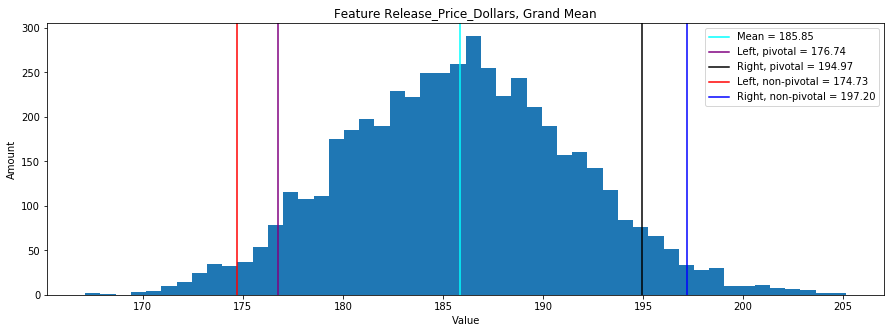

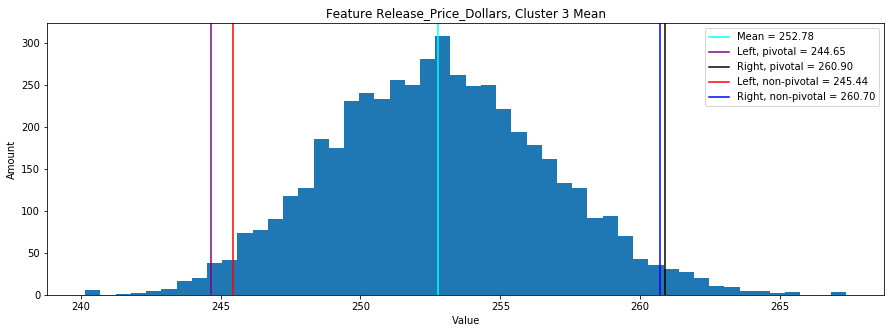

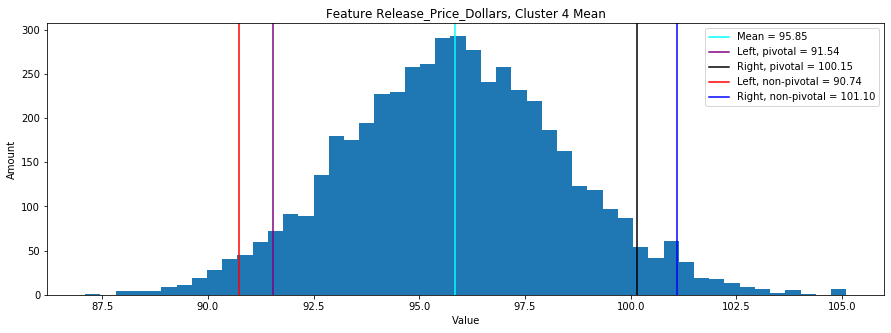

In [13]:
n_resample = len(X)
n_bootstrap = 5000
feature = 'Release_Price_Dollars'

bs = bootstrapping(get_grand_feature_values(X, feature, best5), n_resample, n_bootstrap)
draw_histogram(bs, 'Feature {}, Grand Mean'.format(feature))
x_rs_mean = bs['resampled_means']

for cluster in [2, 3]:
    bs = bootstrapping(get_cluster_feature_values(cluster, X, feature, best5), n_resample, n_bootstrap)
    cluster_mean = bs['resampled_means']
    draw_histogram(bs, 'Feature {}, Cluster {} Mean'.format(feature, cluster+1))
#     plt.figure(figsize=(15, 5))
#     plt.hist(np.subtract(x_rs_mean, cluster_mean), bins=50)

Confidence interval is computed for "Release_Price_Dollars" feature on grand mean:
```
pivotal: [176.74, 194.97]
non-pivotal: [174.73, 197.20]
```
Regarding feature min/max values this difference in small, so pivot and non-pivot bounds are quite similar.


Comparing cluster-means for "Release_Price_Dollars" feature on clusters 3 and 4:
```
cluster3 mean: 252.78
cluster4 mean: 95.78
```
As we can see, they are completely different.

Comparing mean for "Release_Price_Dollars" feature on cluster 3 with grand mean:
```
cluster3 mean: 252.78
grand mean: 185.85
```
As we can see, they are completely different again, but closer. It is OK, regarding clusters difference.

# HW 6

It is seems correct that 'Release_Price_Dollars' will get more or less linear dependency with some other feature. Let's check that:

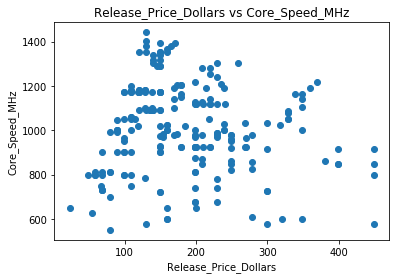

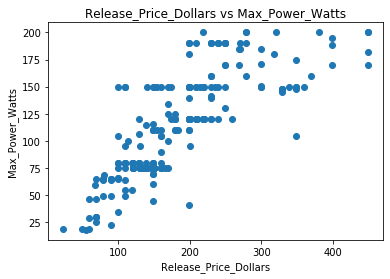

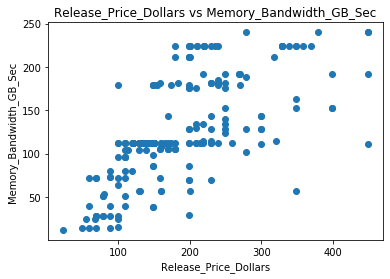

In [14]:
# Just parameters check

for a in ['Release_Price_Dollars']:
    for b in selected_features:
        if a != b:
            plt.xlabel(a)
            plt.ylabel(b)
            plt.title('{} vs {}'.format(a, b))
            plt.scatter(data[a], data[b])
            plt.show()

Scatter plot is the best way to visualize linear regression: we will see the distance between every value and predicted line. Even without line we can detect linear dependency: dots are grouping into something in the shape of line or stripe.

So, our second feature is 'Max_Power_Watts', let's use it as predictor. Let's just use linear regression:

Intercept:		 24.063789728741483
Slope:			 1.4308760915718808
Det. coefficient:	 0.7207058952422762
Cor. coefficient:	 0.7905228972282892


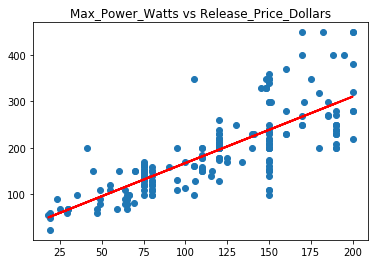

In [15]:
predictor = 'Max_Power_Watts'
target = 'Release_Price_Dollars'
X_data = data[predictor]
Y_data = data[target]
X = X_data.values.reshape(-1,1)
Y = Y_data.values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

regressor = LinearRegression()  
regressor.fit(X_train, y_train)

a = regressor.intercept_[0]
b = regressor.coef_[0][0]
print('Intercept:\t\t', a)
print('Slope:\t\t\t', b)
print('Det. coefficient:\t', r2_score(y_test, regressor.predict(X_test)))
print('Cor. coefficient:\t', np.corrcoef(X_data, Y_data)[0, 1])

plt.title('{} vs {}'.format(predictor, target))
plt.scatter(X, Y)
plt.plot(X, regressor.predict(X), color='red', linewidth=2)
plt.show()

As we can see, it is predicted well. Slope in this case means tangent of angle between x axis and predicted line.

Also let's take another target parameters:

In [16]:
predictors = ['Max_Power_Watts', 'Core_Speed_MHz', 'Memory_Speed_MHz']
target = 'Release_Price_Dollars'
X_data = data[predictors]
Y_data = data[target]
X = X_data
Y = Y_data.values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

regressor = LinearRegression()  
regressor.fit(X_train, y_train)

a = regressor.intercept_
b = regressor.coef_
print('Intercept:\t\t', a[0])
print('Slope:\t\t\t', b[0])
print('Det. coefficient:\t', r2_score(y_test, regressor.predict(X_test)))
up_sum = np.sum(np.absolute(np.subtract(regressor.predict(X_test), y_test)))
low_sum = np.sum(np.absolute(np.subtract(y_test, np.mean(y_test))))
print('MRAE:\t\t\t', np.mean(np.divide(up_sum, low_sum)))

Intercept:		 18.62570951216668
Slope:			 [ 1.38767136 -0.04971116  0.04218138]
Det. coefficient:	 0.731333201054249
MRAE:			 0.45114504176291903
